In [47]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Dataset
We will generate a mock dataset of 1000 quasar spectra derived from a template spectrum. Each template is redshifted by a random value $z\in[1,2]$ with Gaussian noise added to simulate observational uncertainties. The flux of each spectra is sampled at 7 fixed observation wavelengths [4000, 5000, 6000, 7000, 8000, 9000, 10000] $\AA$ and used as the input to the neural network with the corresponding redshift as the target output. The template is an edited version of the composite by Selsing et al. (2016) and is plotted below.

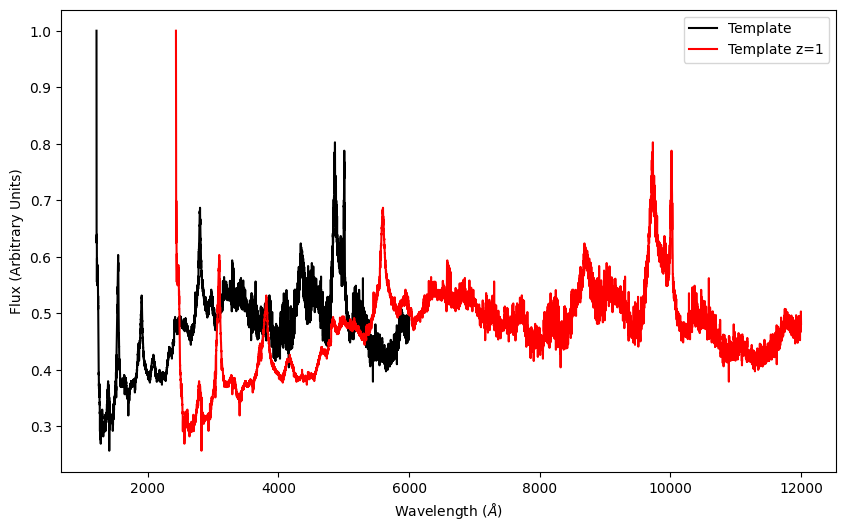

In [57]:
# Load the template spectrum
template = pd.read_csv("template.csv")
wavelength = template["wavelength"].values
flux = template["total"].values
flux = flux / np.max(flux)  # normalize

# Plot the spectrum
plt.figure(figsize=(10, 6))
plt.plot(wavelength, flux, color='k', label=f'Template')
plt.plot(wavelength * (1+1), flux, color='r', label=f'Template z=1')
plt.xlabel(fr"Wavelength ($\AA$)")
plt.ylabel("Flux (Arbitrary Units)")
plt.legend()
plt.show()

To ensure that the mock dataset is the same every time, we use the generating code below to save it into a csv file. 

In [ ]:
# # Define parameters
# num_samples = 1000
# fixed_wavelengths = np.array([4000, 5000, 6000, 7000, 8000, 9000, 10000])
# np.random.seed(42)

# # Generate mock observations
# data = []
# redshifts = np.random.uniform(1.0, 2.0, num_samples)
# for z in redshifts:
#     # Redshift wavelength grid
#     obs_wavelength = wavelength * (1 + z)
    
#     # Interpolate flux onto observed wavelengths
#     interp_func = interp1d(obs_wavelength, flux)
#     sampled_flux = interp_func(fixed_wavelengths)
    
#     # Add Gaussian noise
#     noise = np.random.normal(0, 0.03, size=sampled_flux.shape)
#     noisy_flux = sampled_flux + noise
    
#     data.append(np.append(noisy_flux, z))

# # Save to CSV
# columns = [f"flux_{wl}" for wl in fixed_wavelengths] + ["redshift"]
# df = pd.DataFrame(data, columns=columns)
# df.to_csv("data.csv", index=False)

# Neural Network